# Sider Multitask Classifier

# Baseline 

In [1]:
import numpy as np
import tensorflow as tf
import deepchem as dc

/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
sider_tasks, sider_datasets, transformers = dc.molnet.load_sider(featurizer = 'GraphConv')
train_dataset, valid_dataset, test_dataset = sider_datasets

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [3]:
sider_datasets

(<deepchem.data.datasets.DiskDataset at 0x7f28e02262e8>,
 <deepchem.data.datasets.DiskDataset at 0x7f28959ecf60>)

In [4]:
train_dataset.y.shape

(1141, 27)

In [5]:
valid_dataset.y.shape

(143, 27)

In [6]:
test_dataset.y.shape

(143, 27)

In [7]:
featurizer = dc.feat.CircularFingerprint(size = 1024)

In [8]:
loader = dc.data.CSVLoader(
      tasks=sider_tasks, smiles_field="smiles",
      featurizer=featurizer)

In [9]:
dataset = loader.featurize('sider.csv')

Loading raw samples now.
shard_size: 8192
About to start loading CSV from sider.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 1.937 s
TIMING: dataset construction took 1.989 s
Loading dataset from disk.


In [10]:
sider_tasks

['Hepatobiliary disorders',
 'Metabolism and nutrition disorders',
 'Product issues',
 'Eye disorders',
 'Investigations',
 'Musculoskeletal and connective tissue disorders',
 'Gastrointestinal disorders',
 'Social circumstances',
 'Immune system disorders',
 'Reproductive system and breast disorders',
 'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
 'General disorders and administration site conditions',
 'Endocrine disorders',
 'Surgical and medical procedures',
 'Vascular disorders',
 'Blood and lymphatic system disorders',
 'Skin and subcutaneous tissue disorders',
 'Congenital, familial and genetic disorders',
 'Infections and infestations',
 'Respiratory, thoracic and mediastinal disorders',
 'Psychiatric disorders',
 'Renal and urinary disorders',
 'Pregnancy, puerperium and perinatal conditions',
 'Ear and labyrinth disorders',
 'Cardiac disorders',
 'Nervous system disorders',
 'Injury, poisoning and procedural complications']

In [11]:
splitter = dc.splits.RandomSplitter('sider.csv')
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)
#NOTE THE RENAMING:
valid_dataset, test_dataset = test_dataset, valid_dataset


Computing train/valid/test indices
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


In [12]:
n_features = train_dataset.get_data_shape()[0]

In [13]:
params_dict = {"activation": ["relu"],
               "optimizer": ["Adam"],
               "momentum": [.9],
               "penalty": [0.]
              }

n_features = train_dataset.get_data_shape()[0]
def model_builder(model_params, model_dir):
    model = dc.models.MultitaskClassifier(
    len(sider_tasks), n_features, **model_params)
    return model

In [14]:

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/1
hyperparameters: {'activation': 'relu', 'optimizer': 'Adam', 'momentum': 0.9, 'penalty': 0.0}
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


computed_metrics: [0.7175129948020791, 0.6900485436893204, 0.6524822695035462, 0.6504515599343186, 0.7173913043478262, 0.6892523364485981, 0.8598673300165838, 0.544496487119438, 0.6218604651162791, 0.7983935742971888, 0.6929824561403508, 0.7527777777777778, 0.7261904761904763, 0.4910569105691057, 0.7007319819819819, 0.7166042446941323, 0.8519283746556474, 0.6635154061624651, 0.6458737864077669, 0.6347826086956522, 0.7107393416082028, 0.7129090094128194, 0.5863905325443788, 0.636150234741784, 0.7395786642761093, 0.8187022900763359, 0.6427906976744187]
Model 1/1, Metric mean-roc_auc_score, Validation set 0: 0.691313
	best_validation_score so far: 0.691313
computed_metrics: [0.9223252167496772, 0.9112974291748598, 0.9447777777777777, 0.924949582252953, 0.9417890247702134, 0.9155356446641507, 0.9703862093289833, 0.925221951092882, 0.9272281741509003, 0.919900570887795, 0.9272009435470974, 0.9580427473583093, 0.9140499825844652, 0.9316415449835139, 0.9362061134577826, 0.9318165607573596, 0.

In [15]:
best_dnn

MultitaskClassifier(activation_fns=None, bias_init_consts=None, dropouts=None,
                    layer_sizes=None, n_classes=2, n_features=1024, n_tasks=27,
                    weight_decay_penalty=None, weight_decay_penalty_type=None,
                    weight_init_stddevs=None)

In [16]:
best_hyperparams

('relu', 'Adam', 0.9, 0.0)

In [17]:
all_results

{"('relu', 'Adam', 0.9, 0.0)": 0.691313394773503}

In [18]:
model=model_builder(params_dict,params_dict)
model.fit(train_dataset, nb_epoch=100)

143.9023218107461

In [19]:
obj=best_dnn.fit(train_dataset,**params_dict,epochs=100)

In [20]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
metric_recall_score = dc.metrics.Metric(dc.metrics.recall_score, np.mean,mode="classification")
metric_precision_score = dc.metrics.Metric(dc.metrics.precision_score, np.mean,mode="classification")


In [21]:
train_scores = model.evaluate(train_dataset, [metric], transformers)
print ('rac_auc = %s' % (train_scores))


computed_metrics: [0.9995188464612925, 0.9999289927900371, 1.0, 0.999957439564181, 0.9999318429661941, 0.9999006907509986, 0.9999250507009965, 0.9999948081615699, 0.9998936251044752, 0.9997019584708319, 0.9996741564049256, 0.9999087415946206, 0.9999738766980146, 0.9974211022138484, 0.9999477676341009, 0.9998622098301129, 0.999840572118341, 0.9988974495217853, 0.9999421879079482, 0.9997901007516392, 0.9999624311550918, 0.9999202599525546, 0.9975818735719726, 0.9999551511252428, 0.9999491866230155, 1.0, 0.999850140323152]
rac_auc = {'mean-roc_auc_score': 0.9996752023109978}


In [22]:

train_recall_score = model.evaluate(train_dataset, [metric_recall_score], transformers)
print ('metric_accuracy_score = %s' % (train_recall_score))


computed_metrics: [0.9948717948717949, 0.9987437185929648, 1.0, 0.9943820224719101, 0.9967284623773174, 0.9987531172069826, 1.0, 1.0, 0.9951219512195122, 0.9947735191637631, 0.9831081081081081, 1.0, 0.9923371647509579, 0.9829545454545454, 0.9988826815642458, 0.9942938659058488, 1.0, 0.98, 1.0, 0.9964497041420118, 0.9963144963144963, 0.9958734525447043, 0.9900990099009901, 0.982824427480916, 0.9949622166246851, 1.0, 0.9946595460614153]
metric_accuracy_score = {'mean-recall_score': 0.9946716223984139}


In [23]:
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

computed_metrics: [0.6921231507397041, 0.583495145631068, 0.5886524822695035, 0.666871921182266, 0.6413043478260869, 0.6884735202492211, 0.6865671641791045, 0.5017564402810304, 0.613953488372093, 0.7744979919678714, 0.6588972431077693, 0.7231481481481481, 0.6952380952380952, 0.5443089430894309, 0.7198761261261262, 0.6400332917186851, 0.78099173553719, 0.6827731092436975, 0.6533980582524272, 0.6086956521739131, 0.7048030221262817, 0.6999103541012999, 0.6372781065088757, 0.6130672926447576, 0.6893769610040341, 0.7404580152671756, 0.6509302325581395]


In [24]:
valid_recall_score = model.evaluate(valid_dataset, [metric_recall_score], transformers)
print ('metric_recall_score = %s' % (valid_recall_score))


computed_metrics: [0.6219512195121951, 0.7572815533980582, 0.0, 0.7011494252873564, 0.85, 0.7570093457943925, 0.9328358208955224, 0.2857142857142857, 0.84, 0.7590361445783133, 0.47368421052631576, 0.9185185185185185, 0.34285714285714286, 0.15, 0.8648648648648649, 0.6966292134831461, 0.9621212121212122, 0.3333333333333333, 0.7669902912621359, 0.8, 0.7614678899082569, 0.7422680412371134, 0.15384615384615385, 0.4166666666666667, 0.7422680412371134, 0.9465648854961832, 0.68]
metric_recall_score = {'mean-recall_score': 0.6391503059458622}


In [25]:
test_scores = model.evaluate(test_dataset, [metric], transformers)

computed_metrics: [0.6417910447761194, 0.5922792469744509, 0.4118705035971223, 0.6098484848484849, 0.5904416212946159, 0.584349173553719, 0.5406015037593985, 0.5712535014005603, 0.5747041420118344, 0.6434442270058709, 0.6317774634606317, 0.5675287356321839, 0.6484674329501916, 0.7021475256769374, 0.5538020086083213, 0.6678179824561403, 0.5375000000000001, 0.5762250453720509, 0.5058064516129033, 0.5908139534883721, 0.5832258064516129, 0.6837027914614122, 0.7947658402203857, 0.6032242063492064, 0.6706073509636934, 0.6345514950166113, 0.6081913939937247]


In [26]:
test_recall_score = model.evaluate(test_dataset, [metric_recall_score], transformers)
print ('metric_recall_score = %s' % (test_recall_score))

computed_metrics: [0.6710526315789473, 0.7628865979381443, 0.0, 0.6493506493506493, 0.8333333333333334, 0.7840909090909091, 0.9172932330827067, 0.16666666666666666, 0.8173076923076923, 0.6285714285714286, 0.42857142857142855, 0.9224137931034483, 0.48148148148148145, 0.35294117647058826, 0.8137254901960784, 0.7473684210526316, 0.953125, 0.20689655172413793, 0.7526881720430108, 0.83, 0.7634408602150538, 0.8620689655172413, 0.2727272727272727, 0.5555555555555556, 0.7938144329896907, 0.9069767441860465, 0.7938144329896907]
metric_recall_score = {'mean-recall_score': 0.6543764044719939}


In [27]:
print(train_scores)
print(valid_scores)
print(test_scores)

{'mean-roc_auc_score': 0.9996752023109978}
{'mean-roc_auc_score': 0.6622548162794073}
{'mean-roc_auc_score': 0.6044718123309836}


In [28]:
print(train_recall_score)
print(valid_recall_score)
print(test_recall_score)

{'mean-recall_score': 0.9946716223984139}
{'mean-recall_score': 0.6391503059458622}
{'mean-recall_score': 0.6543764044719939}


In [29]:
test_recall_score

{'mean-recall_score': 0.6543764044719939}

In [30]:
import seaborn as sns


sns.set(rc={'figure.figsize':(10,3)})
sns.set(style="whitegrid")
ax = sns.barplot(x=[test_scores['mean-roc_auc_score'],test_recall_score['mean-recall_score']],
                 y=['roc_auc_score','recall_score'])
ax.set(xlim=(0, None))

[(0, 0.6870952246955936)]


# hyperparameters

In [31]:
params_dict = {"activation": ["relu","sigmoid","tanh"],
               "optimizer": ['RMSprop','adam'],
               "momentum": [.9],
               "dropouts": [.5,0.2],
               "learning_rate": [1e-3],
               "batch_size": [50],
               "nb_layers": [64,128.,256,512],
               "penalty": [0.]
              }

n_features = train_dataset.get_data_shape()[0]

def model_builder(model_params, model_dir):
    model = dc.models.MultitaskClassifier(
    len(sider_tasks), n_features, **model_params)
    return model


In [32]:

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/48
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.5, 'learning_rate': 0.001, 'batch_size': 50, 'nb_layers': 64, 'penalty': 0.0}
computed_metrics: [0.7217113154738105, 0.7026699029126213, 0.7198581560283688, 0.6510673234811166, 0.7130434782608697, 0.6991173416407062, 0.8416252072968491, 0.5464480874316939, 0.656046511627907, 0.7973895582329316, 0.6892230576441103, 0.7074074074074075, 0.7002645502645504, 0.5341463414634147, 0.7088963963963963, 0.7114024136496047, 0.8519283746556474, 0.6607142857142858, 0.6589805825242718, 0.6562111801242236, 0.7420399352401511, 0.7077543702375616, 0.565680473372781, 0.6441705790297341, 0.7454056476916181, 0.8282442748091603, 0.6516279069767441]
Model 1/48, Metric mean-roc_auc_score, Validation set 0: 0.696781
	best_validation_score so far: 0.696781
Fitting model 2/48
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.5, 'learning_rate': 0.001, 'bat

computed_metrics: [0.7225109956017594, 0.6805825242718447, 0.7056737588652482, 0.6496305418719213, 0.6920289855072463, 0.7084631360332294, 0.8449419568822554, 0.5382513661202186, 0.650232558139535, 0.7951807228915663, 0.6764411027568922, 0.7388888888888889, 0.7137566137566138, 0.5166666666666666, 0.7173423423423424, 0.7051602163961714, 0.862258953168044, 0.665266106442577, 0.654126213592233, 0.6406832298136647, 0.7247706422018348, 0.7050649932765576, 0.6029585798816568, 0.639866979655712, 0.7409233527566115, 0.8231552162849873, 0.6325581395348837]
Model 11/48, Metric mean-roc_auc_score, Validation set 10: 0.694348
	best_validation_score so far: 0.697301
Fitting model 12/48
hyperparameters: {'activation': 'relu', 'optimizer': 'adam', 'momentum': 0.9, 'dropouts': 0.5, 'learning_rate': 0.001, 'batch_size': 50, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.7277089164334266, 0.7055825242718448, 0.75177304964539, 0.6600985221674878, 0.697463768115942, 0.6936656282450675, 0.862354892

computed_metrics: [0.7205117952818871, 0.6686893203883495, 0.6382978723404256, 0.6471674876847291, 0.7050724637681158, 0.6882139148494288, 0.8631840796019901, 0.5316159250585479, 0.6504651162790698, 0.7871485943775101, 0.6696741854636592, 0.7462962962962962, 0.7108465608465608, 0.525609756097561, 0.7024211711711712, 0.6995422388680816, 0.8181818181818182, 0.6624649859943977, 0.6529126213592233, 0.6276397515527949, 0.7231516459794927, 0.7164948453608248, 0.6384615384615384, 0.6422143974960877, 0.7200806813088301, 0.8187022900763359, 0.6506976744186046]
Model 21/48, Metric mean-roc_auc_score, Validation set 20: 0.689843
	best_validation_score so far: 0.699483
Fitting model 22/48
hyperparameters: {'activation': 'sigmoid', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.2, 'learning_rate': 0.001, 'batch_size': 50, 'nb_layers': 128.0, 'penalty': 0.0}
computed_metrics: [0.7207117153138745, 0.6364077669902914, 0.648936170212766, 0.6410098522167489, 0.7043478260869566, 0.686656282450675

computed_metrics: [0.7233106757297081, 0.6560679611650486, 0.6418439716312057, 0.6631773399014778, 0.7047101449275361, 0.6845794392523364, 0.8383084577114428, 0.5472287275565964, 0.6441860465116279, 0.7939759036144578, 0.6606516290726816, 0.7444444444444445, 0.7193121693121693, 0.5150406504065042, 0.7080518018018018, 0.7047440699126093, 0.8581267217630855, 0.6582633053221288, 0.6439320388349514, 0.6273291925465839, 0.7417701025364275, 0.7133572389063201, 0.6236686390532544, 0.6384976525821595, 0.7281488121918422, 0.8085241730279898, 0.6562790697674419]
Model 31/48, Metric mean-roc_auc_score, Validation set 30: 0.690649
	best_validation_score so far: 0.699483
Fitting model 32/48
hyperparameters: {'activation': 'sigmoid', 'optimizer': 'adam', 'momentum': 0.9, 'dropouts': 0.2, 'learning_rate': 0.001, 'batch_size': 50, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.7249100359856058, 0.6601941747572815, 0.6347517730496455, 0.652504105090312, 0.6963768115942031, 0.6936656282450675, 0

computed_metrics: [0.7361055577768891, 0.6834951456310681, 0.6702127659574468, 0.6545566502463054, 0.722463768115942, 0.6985981308411214, 0.8250414593698177, 0.5565964090554255, 0.6655813953488372, 0.7953815261044177, 0.6902255639097745, 0.7222222222222222, 0.7142857142857143, 0.5158536585365854, 0.7088963963963963, 0.717852684144819, 0.8388429752066116, 0.6729691876750701, 0.6728155339805825, 0.6487577639751553, 0.7304371289800324, 0.7185118780815778, 0.6053254437869823, 0.6406494522691706, 0.7321828776333482, 0.799618320610687, 0.6458139534883721]
Model 41/48, Metric mean-roc_auc_score, Validation set 40: 0.695678
	best_validation_score so far: 0.699483
Fitting model 42/48
hyperparameters: {'activation': 'tanh', 'optimizer': 'adam', 'momentum': 0.9, 'dropouts': 0.5, 'learning_rate': 0.001, 'batch_size': 50, 'nb_layers': 128.0, 'penalty': 0.0}
computed_metrics: [0.734906037584966, 0.6800970873786407, 0.6595744680851063, 0.6689244663382594, 0.6960144927536231, 0.7017133956386293, 0.827

In [33]:
#model=model_builder(params_dict,params_dict)
#model.fit(train_dataset,nb_epoch=100)

In [34]:
obj=best_dnn.fit(train_dataset,**params_dict)

In [35]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

In [36]:
train_scores = best_dnn.evaluate(train_dataset, [metric], transformers)
print(train_scores)


computed_metrics: [0.981889872717211, 0.9805749763309299, 0.9957222222222222, 0.983833582148189, 0.990419068390715, 0.9801602189217222, 0.9953663698086589, 0.9886298738383261, 0.9785236684142542, 0.9796471434102096, 0.9804393890932352, 0.9939433237271853, 0.9829806687565309, 0.9828367875647668, 0.9906004451105964, 0.9839887822591105, 0.9931446010886646, 0.9868411264612115, 0.9830088396553653, 0.9871601631217016, 0.9868734455890419, 0.9768089362013171, 0.9847201066260473, 0.9797143899934428, 0.9877140513505469, 0.9948058616739741, 0.9789106563853845]
{'mean-roc_auc_score': 0.9855280952170579}


In [37]:
valid_scores = best_dnn.evaluate(valid_dataset, [metric], transformers)
print(valid_scores)


computed_metrics: [0.7135145941623351, 0.6317961165048545, 0.7553191489361702, 0.6594827586206896, 0.6996376811594203, 0.7027518172377986, 0.8150912106135988, 0.5117096018735363, 0.6479069767441861, 0.7891566265060241, 0.6739348370927318, 0.7324074074074074, 0.692063492063492, 0.5195121951219512, 0.7226914414414414, 0.6783187682064087, 0.8319559228650137, 0.6491596638655462, 0.6512135922330097, 0.6375776397515527, 0.7433890987587696, 0.7077543702375616, 0.5775147928994082, 0.636737089201878, 0.7164948453608249, 0.7888040712468194, 0.6427906976744187]
{'mean-roc_auc_score': 0.6862476465846981}


In [38]:
test_scores_v1 = best_dnn.evaluate(test_dataset, [metric], transformers)
print(test_scores_v1)

computed_metrics: [0.6822466614296936, 0.612057373375168, 0.40287769784172656, 0.6271153089334907, 0.6243194192377495, 0.6214876033057852, 0.6157894736842107, 0.5196078431372548, 0.6131656804733727, 0.6688845401174168, 0.644978783592645, 0.5839719029374202, 0.6411238825031929, 0.6792717086834734, 0.6006695361071257, 0.7109649122807018, 0.5401041666666666, 0.5834845735027223, 0.538494623655914, 0.6186046511627907, 0.5905376344086022, 0.6709770114942529, 0.743801652892562, 0.589484126984127, 0.6772747646795159, 0.699889258028793, 0.6111609143881668]
{'mean-roc_auc_score': 0.6189757668705385}


[(0, 0.6499245552140653)]

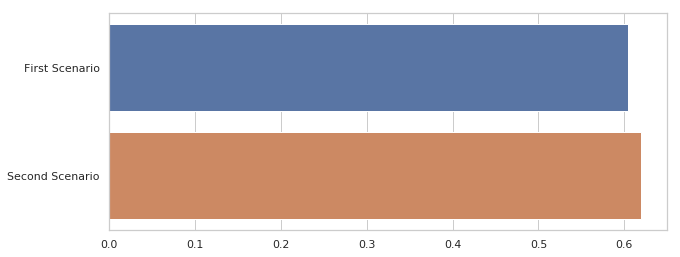

In [39]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,4)})
sns.set(style="whitegrid")
ax = sns.barplot(x=[test_scores['mean-roc_auc_score'],test_scores_v1['mean-roc_auc_score']],
                 y=['First Scenario','Second Scenario'])
ax.set(xlim=(0, None))